In [7]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [35]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "ro-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "bx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

# Recurrent Neural Network
RNN sono una classe di reti neuronali applicabili a sequenza o serie temporali di lunghezza arbitraria.

Le reti feedforward o sequenziali viste sinora seguono un flusso la cui direzione procede dai livelli di input fino a quelli di output in maniera lineare.  Una RNN e' simile a questo tipo di reti tranne che presenta un collegamento all'indietro, come mostrato nella seguente figura che riporta la piu' semplice RNN.

![]()

Ad ogni step $t$ , la rete riceve  in input il segnale $\mathbf{x}_t$ e l'output $\mathbf{y}_{t-1}$ - l'output al passo precedente. 

Una rappresentazione equivalente alla precedente e' data dallo _srotolamento_ della rete, come mostrato in figura:

![](unfolding.png)

in cui viene creato un layer di unita' ricorrenti o ricorsive.

In questa architettura ogni unita' riceve  due insiemi distinti di input:
- gli input dal livello di input
- le attivazioni dallo stesso livello generate al passo $t-1$

Ad ogni passo $t$ le unita' del livello hidden ricevono in input $\mathbf{x}_t$ e $\mathbf{h}_{t-1}$, cioe' i valori precedenti del livello hidden.

![](unfolding_2.png)

Ogni collegamento riportato in figura ha una matrice dei pesi associata che non dipendono dal tempo $t$. Le matrici dei pesi sono:
- $\mathbf{W}_{xh}$: la matrice dei pesi tra input $\mathbf{x}_t$ e $\mathbf{h}$
- $\mathbf{W}_{hh}$: la matrice associata al collegamento ricorrente
- $\mathbf{W}_{hy}$: la matrice tra il livello $\mathbf{h}$ e il livello di output $\mathbf{y}$

Il calcolo dell'attivazione e' simili alle reti sequenziali:

$$\mathbf{z}_h^t = \mathbf{W}_{hx}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h$$

da cui

$$\mathbf{h}_t = \sigma_h(\mathbf{z}_h^t)=\sigma(\mathbf{W}_{hx}\mathbf{x}_t + \mathbf{W}_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h) $$

riscrivibile come 

$$\mathbf{h}_t = \sigma_h([\mathbf{W}_{xh};\mathbf{W}_{hh}][\mathbf{x}_t^T;\mathbf{h}_{t-1}^T]^T + \mathbf{b}_h)$$

<br>

![](comp_schema.png)

Dal momento che l'output di un'unita' al tempo $t$ e' funzione dell'input dei passi precedenti, possiamo dire che esiste una sorta di _memoria_. Un layer con la precedente struttura e' infatti detto $memory cell$. In generale una generica cella di memoria e' una funzione $f(\mathbf{h}_{t-1},\mathbf{x}_t)$.

### Sequenze di input e output
![](rnn_inout.png)

## Training RNNs
Per addestrare una RNN si sfrutta la rappresentazione estesa della rete nel tempo e si applica backpropagation: **backpropagation through time**

![]()

### Time series
Un problema a cui applicare RNN e' il forecasting di serie temporali univariate o multivariate.

In [5]:
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

In [11]:
series = generate_time_series(10000, n_steps + 1)

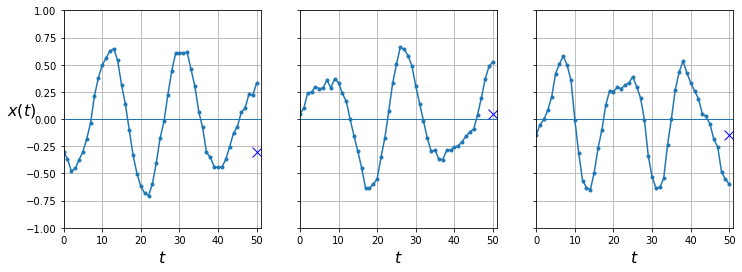

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(series[col, :, 0], series[col, 0],
                y_label=("$x(t)$" if col==0 else None))

Definiamo training, validation e test set:

In [6]:
np.random.seed(42)

n_steps = 50
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

E' utile, come fatto per il perceptron, definire alcuni modelli baseline per confrontare le performance ottenute.

Il primo modello restituisce il valore della serie al tempo $t-1$.

In [14]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

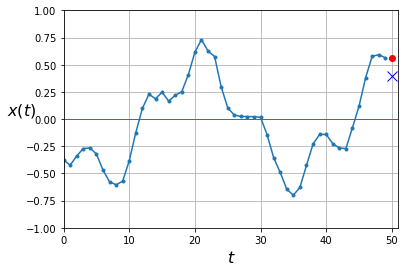

In [21]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Il secondo modello e' una rete fully connected.

In [22]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0828 - val_loss: 0.0462
Epoch 2/20
219/219 [==============================] - 0s 589us/step - loss: 0.0354 - val_loss: 0.0276
Epoch 3/20
219/219 [==============================] - 0s 589us/step - loss: 0.0229 - val_loss: 0.0188
Epoch 4/20
219/219 [==============================] - 0s 584us/step - loss: 0.0164 - val_loss: 0.0140
Epoch 5/20
219/219 [==============================] - 0s 584us/step - loss: 0.0126 - val_loss: 0.0111
Epoch 6/20
219/219 [==============================] - 0s 598us/step - loss: 0.0102 - val_loss: 0.0094
Epoch 7/20
219/219 [==============================] - 0s 589us/step - loss: 0.0088 - val_loss: 0.0083
Epoch 8/20
219/219 [==============================] - 0s 580us/step - loss: 0.0078 - val_loss: 0.0075
Epoch 9/20
219/219 [==============================] - 0s 594us/step - loss: 0.0072 - val_loss: 0.0070
Epoch 10/20
219/219 [==============================] - 0s 598us/step - loss: 0.0068 

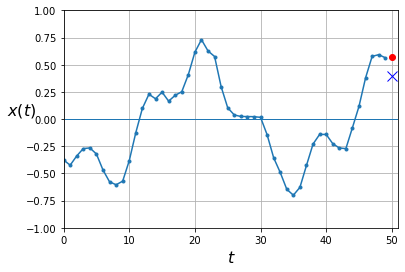

In [24]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

Infine definiamo un RNN con una sola unita' ricorrente e funzione di attivazione $tanh$ - default.

In [25]:
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

model.compile(loss="mse", optimizer='sgd')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0836 - val_loss: 0.0471
Epoch 2/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0409 - val_loss: 0.0380
Epoch 3/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0344 - val_loss: 0.0327
Epoch 4/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0303 - val_loss: 0.0292
Epoch 5/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0274 - val_loss: 0.0266
Epoch 6/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0253 - val_loss: 0.0246
Epoch 7/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0236 - val_loss: 0.0230
Epoch 8/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0222 - val_loss: 0.0217
Epoch 9/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0211 - val_loss: 0.0206
Epoch 10/20
219/219 [==============================] - 1s 5ms/step - loss: 0.0201 - val_loss: 0.0197

Infine inseriamo piu' hidden layer costituiti da piu' unita' ricorrenti

In [26]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0415 - val_loss: 0.0124
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0108 - val_loss: 0.0094
Epoch 3/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0079 - val_loss: 0.0069
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0066 - val_loss: 0.0068
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0059 - val_loss: 0.0057
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0054 - val_loss: 0.0053
Epoch 7/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 8/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0049 - val_loss: 0.0047
Epoch 9/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0046 - val_loss: 0.0044
Epoch 10/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0044 - val_lo

Dal momento che per l'ultimo layer non ci interessa l'ouput $h_{out}$, possiamo utilizzare un livello denso con una singola unita' di output.

In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0375 - val_loss: 0.0151
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0118 - val_loss: 0.0094
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0081 - val_loss: 0.0071
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0064 - val_loss: 0.0061
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0055 - val_loss: 0.0051
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0045 - val_loss: 0.0048
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0042 - val_loss: 0.0042
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0039 - val_lo

Per predirre i prossimi $k$ valori futuri come primo approccio posso utilizzare le predizioni eseguite fino al passo $t+1$ come input del mio modello. In sostanza, predico sulle predizioni. 

Ho un problema di accumulazione dell'errore di predizione.

In [28]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [29]:
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

In [30]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.023481648

In [31]:
Y_naive_pred = Y_valid[:, -1:]
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_naive_pred))

0.21728522

In [33]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 0s 973us/step - loss: 0.2388 - val_loss: 0.1641
Epoch 2/20
219/219 [==============================] - 0s 598us/step - loss: 0.1337 - val_loss: 0.1113
Epoch 3/20
219/219 [==============================] - 0s 603us/step - loss: 0.1010 - val_loss: 0.0911
Epoch 4/20
219/219 [==============================] - 0s 594us/step - loss: 0.0867 - val_loss: 0.0807
Epoch 5/20
219/219 [==============================] - 0s 626us/step - loss: 0.0786 - val_loss: 0.0742
Epoch 6/20
219/219 [==============================] - 0s 589us/step - loss: 0.0730 - val_loss: 0.0695
Epoch 7/20
219/219 [==============================] - 0s 653us/step - loss: 0.0688 - val_loss: 0.0658
Epoch 8/20
219/219 [==============================] - 0s 616us/step - loss: 0.0654 - val_loss: 0.0628
Epoch 9/20
219/219 [==============================] - 0s 637us/step - loss: 0.0626 - val_loss: 0.0602
Epoch 10/20
219/219 [==============================] - 0s 626us/step - loss: 0.060

Definiamo un RNN che restituisce un vettore di 10 elementi

In [34]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss="mse", optimizer="sgd")
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 13ms/step - loss: 0.1239 - val_loss: 0.0874
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0761 - val_loss: 0.0666
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0599 - val_loss: 0.0547
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0521 - val_loss: 0.0543
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0475 - val_loss: 0.0537
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0450 - val_loss: 0.0423
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0430 - val_loss: 0.0407
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0417 - val_loss: 0.0396
Epoch 9/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0406 - val_loss: 0.0394
Epoch 10/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0393 - val_lo

In [36]:
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

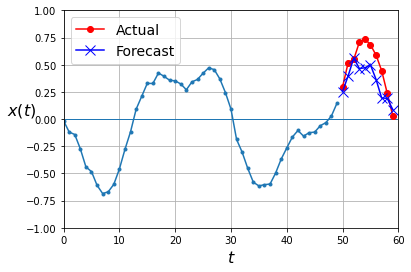

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

Possiamo addestrare il modello in modo che predica i prossimi $k$ valori ad ogni time step, anziche' all'ultimo step $t=50$. Sfrutto gli aggiornamenti del gradiente provenienti da tutti gli output $y_{t}$. Il modello risultante e' nella categoria many-to-many.

Dobbiamo modificare il vettore delle etichette = sequenza di vettori

In [38]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]

Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [40]:
X_train[1], Y_train[1]

(array([[ 0.16071744],
        [ 0.33270544],
        [ 0.4081828 ],
        [ 0.4976635 ],
        [ 0.49415174],
        [ 0.43839103],
        [ 0.34964216],
        [ 0.0542891 ],
        [-0.13685137],
        [-0.40073237],
        [-0.58254945],
        [-0.7002117 ],
        [-0.69520634],
        [-0.55163807],
        [-0.36490557],
        [-0.07642734],
        [ 0.14804491],
        [ 0.3851047 ],
        [ 0.44849455],
        [ 0.48018503],
        [ 0.5180547 ],
        [ 0.38520503],
        [ 0.29558703],
        [ 0.16487691],
        [ 0.06369584],
        [-0.00211993],
        [-0.10867674],
        [-0.16803105],
        [-0.19494142],
        [-0.29977253],
        [-0.3587458 ],
        [-0.49475747],
        [-0.4645386 ],
        [-0.45897326],
        [-0.3275451 ],
        [-0.1321671 ],
        [ 0.08814813],
        [ 0.39118436],
        [ 0.5467701 ],
        [ 0.7076157 ],
        [ 0.6954727 ],
        [ 0.5772617 ],
        [ 0.35436156],
        [ 0

Ogni layer deve restituire sempre una sequenza => **return_sequence=True**. Inoltre, possiamo utilizzare il layer **TimeDistributed** per applicare il layer ad ongi time step della sequenza di input.

In [41]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

La loss function si calcola sull'ouput dell'ultimo time step.

In [44]:
@tf.autograph.experimental.do_not_convert
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

In [45]:
model.compile(loss="mse", optimizer='sgd', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0202 - last_time_step_mse: 0.0070 - val_loss: 0.0199 - val_last_time_step_mse: 0.0067
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0199 - last_time_step_mse: 0.0067 - val_loss: 0.0198 - val_last_time_step_mse: 0.0066
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0198 - last_time_step_mse: 0.0066 - val_loss: 0.0198 - val_last_time_step_mse: 0.0065
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0198 - last_time_step_mse: 0.0066 - val_loss: 0.0198 - val_last_time_step_mse: 0.0065
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0198 - last_time_step_mse: 0.0065 - val_loss: 0.0197 - val_last_time_step_mse: 0.0065
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0197 - last_time_step_mse: 0.0065 - val_loss: 0.0197 - val_last_time_step_mse: 0.0064
Epoch 7/20
219/219 [==

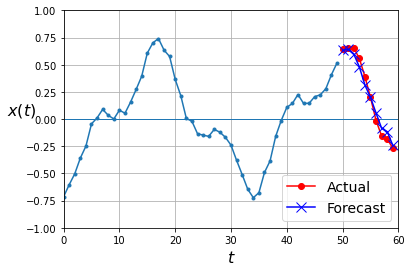

In [46]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

## Long memory cells
Usando la cella di memoria base lo stato dei primi elementi della sequenza puo' non influire sulla predizione al tempo $t$. Per alleviare questo fenomeno sono state proposte diversi cell con memoria a lungo termine - long-term memory.

### Long short-term memory - LSTM

![](lstm_cell.png)

dove informalmente $\mathbf{h}_t$ rappresenta la memoria a breve termine, mentre $\mathbf{c}_t$ rappresenta la memoria a lungo termine.

![](lstm_equation.png)

### Gated Recurrent Unit - GRU

![](gru.png)

I vettori $h$ e $c$ vengono uniti. C'e' un solo gate controller $z$ che controlla forget e input gate. C'e' un nuovo gae controller che agisce sull'input del main gate $g$ e sceglie quale parte dello stato precedente utilizzare. 

![](gru_equation.png)

In Keras vengono rsi disponibili i due layers: **LSTM** e **GRU**

In [49]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="sgd", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0800 - last_time_step_mse: 0.0642 - val_loss: 0.0560 - val_last_time_step_mse: 0.0357
Epoch 2/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0498 - last_time_step_mse: 0.0287 - val_loss: 0.0444 - val_last_time_step_mse: 0.0210
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0415 - last_time_step_mse: 0.0191 - val_loss: 0.0393 - val_last_time_step_mse: 0.0183
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0369 - last_time_step_mse: 0.0155 - val_loss: 0.0351 - val_last_time_step_mse: 0.0144
Epoch 5/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0342 - last_time_step_mse: 0.0137 - val_loss: 0.0330 - val_last_time_step_mse: 0.0139
Epoch 6/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0324 - last_time_step_mse: 0.0130 - val_loss: 0.0313 - val_last_time_step_mse: 0.0125
Epoch 7/20
219/219 [==

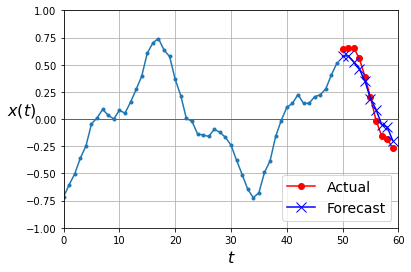

In [50]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)

In [51]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 8s 38ms/step - loss: 0.0745 - last_time_step_mse: 0.0658 - val_loss: 0.0522 - val_last_time_step_mse: 0.0405
Epoch 2/20
219/219 [==============================] - 7s 34ms/step - loss: 0.0474 - last_time_step_mse: 0.0359 - val_loss: 0.0440 - val_last_time_step_mse: 0.0327
Epoch 3/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0419 - last_time_step_mse: 0.0302 - val_loss: 0.0395 - val_last_time_step_mse: 0.0281
Epoch 4/20
219/219 [==============================] - 7s 32ms/step - loss: 0.0374 - last_time_step_mse: 0.0247 - val_loss: 0.0347 - val_last_time_step_mse: 0.0213
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0331 - last_time_step_mse: 0.0192 - val_loss: 0.0317 - val_last_time_step_mse: 0.0174
Epoch 6/20
219/219 [==============================] - 6s 30ms/step - loss: 0.0304 - last_time_step_mse: 0.0152 - val_loss: 0.0293 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

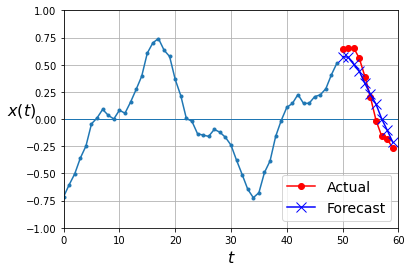

In [53]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]
plot_multiple_forecasts(X_new, Y_new, Y_pred)
